# Topic Extraction and Statistical Modeling

## Import

First, I import the tidy data set from the second notebook, and reset the numeric dtypes.

In [1]:
import pandas as pd
import numpy as np

In [2]:
visas = pd.read_csv('/data/markellekelly/visas.csv',parse_dates=['decision_date'],
                   dtype=str,index_col=0)

In [3]:
numeric_list = ['employer_num_employees','job_info_experience_num_months','overall_wage_offer','employer_desperation',
               'annual_wage']
for x in numeric_list:
    visas[x] = visas[x].apply(pd.to_numeric)

## Not Asked Signal

Since slightly different information was recorded each year, I set values to -1 if the question was not asked on that visa application, differentiating between not asked and asked, but not answered, for the purpose of machine learning.

In [4]:
def check_missing(ind1,ind2,colname):
    '''Ensures that all values are missing where they should be'''
    i=ind1
    check=True
    while i <= ind2:
        if pd.notnull(visas[colname][i]):
            check= False
        i += 1
    assert check

In [5]:
list1 = ['employer_num_employees','foreign_worker_info_birth_country',
         'foreign_worker_info_education','foreign_worker_info_inst',
         'ji_live_in_domestic_service','job_info_education',
         'job_info_experience','job_info_experience_num_months',
         'job_info_foreign_ed','job_info_foreign_lang_req',
         'job_info_work_postal_code','ri_layoff_in_past_six_months',
         'employer_desperation','professional_occupation']
for x in list1:
    check_missing(0,126847,x)
    visas.loc[0:126848,x] = "-1"

## Topic Extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

I used three different methods of unsupervised topic extraction to model 15 topics of the all_text column, attempting to describe the different job types/industries on visa applications. The first two methods are different types of non-negative matrix factorization (Frobenius and Kullback-Leiber), and the last model uses latent dirichlet allocation.

The first function I wrote creates a dictionary of the topics and their top words, and the second prints these in a nicely formatted way, based loosely on the function for printing in this example: http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [6]:
def list_top_words(model, feature_names, top_words):
    '''Creates and returns a dictionary with keys corresponding to the topic and values of
    lists containing the top words of that topic'''
    topdict = {}
    for topic_idx, topic in enumerate(model.components_):
        keyname = "Topic {0}".format(topic_idx)
        topdict[keyname] = [feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]
    return topdict

In [7]:
def print_top_words(topdict):
    '''Prints the topics and their top words based on the input topic dictionary'''
    for key in topdict:
        string = key + ': '
        string += ' '.join([x for x in topdict[key]])
        print(string)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [9]:
features = 1000
components = 15
top_words = 15

In [10]:
v = TfidfVectorizer(max_df=0.95, min_df=2,max_features=features, stop_words='english')
tfidf = v.fit_transform(visas['all_text'])
cv = CountVectorizer(max_df=0.95, min_df=2,max_features=features,stop_words='english')
tdm = cv.fit_transform(visas['all_text'])

### Non-negative Matrix Factorization (Frobenius norm)

Non-negative matrix factorization performs topic extraction with two non-negative matrices; I used NMF from sklearn.decomposition. The Frobenius norm is the default value of the beta loss parameter.

In [11]:
#Note: Takes about one minute to run:
nmf = NMF(n_components=components, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf)

In [12]:
tfidf_feature_names = v.get_feature_names()
fnmftopicdict = list_top_words(nmf, tfidf_feature_names, top_words)
print_top_words(fnmftopicdict)

Topic 0: programming custom computer services applications developers engineers analysts programmer analyst programmers administrators database sr network
Topic 1: systems computer design analysts services related analyst network administrators bus iv consultant sci administrator math
Topic 2: science computer related engineer engineering field software senior developer programmer technical development analyst sr ii
Topic 3: engineering electrical engineer electronics related electronic field manufacturing senior engineers software communication technical communications engg
Topic 4: mfg advanced manufacturing engineers semiconductor electronics electronic component equipment computer device materials communications peripheral scie
Topic 5: business administration marketing analyst manager management research managers related market analysts operations specialists accounting senior
Topic 6: sci comp eng math bus analyst info field ii systems engg electronic physics closely iv
Topic 7: 

### Non-negative Matrix Factorization (generalized Kullback-Leiber divergence)

This second type of topic modeling still uses non-negative matrix factorization, but with the Kullback-Leiber norm (equivalent to setting the beta loss parameter to 1, instead of 2). 

In [13]:
#Note: Takes about two minutes to run:
nmf = NMF(n_components=components, random_state=1, beta_loss='kullback-leibler',
          solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5).fit(tfidf)

In [14]:
tfidf_feature_names = v.get_feature_names()
knmftopicdict = list_top_words(nmf, tfidf_feature_names, top_words)
print_top_words(knmftopicdict)

Topic 0: software services developers applications computer programming custom science systems developer engineering analyst programmer engineer related
Topic 1: systems computer analysts analyst related science design engineering network administrators field senior administrator consultant sr
Topic 2: related engineer science field engineering software developers electronic electrical senior web development shopping ii technical
Topic 3: engineering manufacturing engineer engineers electrical electronics mechanical industrial equipment senior product power sales quality staff
Topic 4: manufacturing mfg engineers semiconductor advanced computer electronic electronics component equipment device television scie wireless radio
Topic 5: business managers administration marketing manager research stores retail management specialists market wholesalers operations merchant specialist
Topic 6: sci math comp eng services engineering bus info engg rel sys analyst field ii phys
Topic 7: schools u

### Latent Dirichlet Allocation

This final topic model uses latent dirichlet allocation, also from sklearn.decomposition, to find latent, or hidden, topics based on a vector of words.

In [15]:
lda = LatentDirichletAllocation(n_components=components, max_iter=5, learning_method='online',
                                learning_offset=50.,random_state=0)

In [16]:
#Note: Takes about four minutes to run:
lda.fit(tdm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=15, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [17]:
tf_feature_names = cv.get_feature_names()
ldatopicdict = list_top_words(lda, tf_feature_names, top_words)
print_top_words(ldatopicdict)

Topic 0: financial finance related investment banking activities securities insurance architectural analysts commercial dealing services cleaners designer
Topic 1: bus industrial sales wholesalers merchant tech search portals equipment transportation miscellaneous machinery supplies head goods
Topic 2: field electronic development specialists specialist sciences associate shopping closely materials physical mental life physician educ
Topic 3: information manufacturing technology medicine computer electronic semiconductor component product managers engineers market electronics device advanced
Topic 4: ii communication staff construction iv applied related workers family java member environmental social building specialty
Topic 5: manager poultry general medical meat cutters stores fish trimmers managers support surgical hospitals workers internal
Topic 6: comp senior engg health administrators network rel sys offices database phys physicians admin telecommunications administrator
Topic 

## Primary Topic Determination using Word Counts

Of the three topic models created, I chose the Frobenius Non-negative Matrix Factorization model because it made the clearest distinction between hospital and restaurant topics (otherwise, all three models were very similar). To include these topics in my data set for modeling, I wrote a function that uses basic word counts to determine the most relevant topic for each observation. I created a new column in my data set containing each applicant's determined primary topic.

In [18]:
def primary_topic(x):
    '''Using word counts, determines the most relevant topic for an observation'''
    countsdict={'Topic {0}'.format(x):0 for x in range(0,15)}
    for word in x.split(' '):
        for key in fnmftopicdict:
            if word.lower() in fnmftopicdict[key]:
                countsdict[key] += 1
    if max(countsdict.values()) == 0:
        return 'None'
    return max(countsdict, key=countsdict.get)

In [19]:
visas['topic'] = visas['all_text'].apply(primary_topic)

## Feature Engineering

Since there are too many different employers in this data set to create dummy variables for all employers, I made a list of all employers with over 500 applicants, and only included those 48 employers in a new column. In this new column, if the applicant's employer was not among these top 48, the value is simply "Other".

In [20]:
visasemployers = visas.groupby('employer_name')['case_no'].aggregate('count').reset_index().sort_values(by='case_no',ascending=False)
visastopemployers = visasemployers[visasemployers['case_no']>=500]
topemployers = list(visastopemployers['employer_name'])

In [21]:
def simple_employer(x):
    '''If employer is in the top 48 employers (more than 500 applicants), return the employer name.
    Otherwise, return a string of the word Other.'''
    if x in topemployers:
        return x
    return "Other"

In [22]:
visas['employer_simple'] = visas['employer_name'].apply(simple_employer)

In [23]:
def get_year(x):
    if pd.notnull(x):
        return x.year
    return x

In [24]:
visas['decision_year'] = visas['decision_date'].apply(get_year)

I then used pandas.get_dummies to create dummy variables for categorical columns of the data set, except for very large categorical variables (like the original employer_name column) which could not be included due to limited memory.

In [25]:
categorical = ['case_status','class_of_admission','foreign_worker_info_birth_country',
               'foreign_worker_info_education','ji_live_in_domestic_service','job_info_foreign_ed',
              'job_info_foreign_lang_req','job_info_education','naics_code','pw_level_9089',
               'ri_layoff_in_past_six_months','wage_offer_unit_of_pay_9089',
               'professional_occupation','topic','employer_simple','decision_year']
for data in categorical:
    visas[data] = pd.get_dummies(visas[data], drop_first = True)

## Logistic Regression with 5-fold Cross Validation

I first attempted to model whether applications will be approved or denied using logistic regression (with 5-fold cross validation). Since the data set is very unbalanced, I spent a lot of time adjusting the class_weight parameter of sklearn.linear_model's LogisticRegressionCV, but was unable to accurately predict the denial of applications (only their approval). For this and every model, I used train_test_split with a test size of 25%.

In [26]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split

In [27]:
lreg = LogisticRegressionCV(cv=5,class_weight={0:.149, 1:.851})

In [28]:
visas_non_null = visas.dropna(subset=['class_of_admission','employer_num_employees','foreign_worker_info_birth_country',
                 'foreign_worker_info_education','ji_live_in_domestic_service','job_info_foreign_ed',
                 'job_info_foreign_lang_req','job_info_experience_num_months','job_info_education','decision_year',
                 'naics_code','pw_level_9089','ri_layoff_in_past_six_months','wage_offer_unit_of_pay_9089',
                 'employer_desperation','annual_wage','professional_occupation'])

In [29]:
X = visas_non_null[['class_of_admission','employer_num_employees','decision_year','foreign_worker_info_birth_country',
                 'foreign_worker_info_education','ji_live_in_domestic_service','job_info_foreign_ed',
                    'job_info_foreign_lang_req','job_info_experience_num_months','job_info_education',
                 'naics_code','pw_level_9089','ri_layoff_in_past_six_months','wage_offer_unit_of_pay_9089',
                 'employer_desperation','annual_wage','professional_occupation','topic','employer_simple']]

In [30]:
y=visas_non_null['case_status']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=1)

In [32]:
lreg.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight={0: 0.149, 1: 0.851}, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [33]:
y_pred = lreg.predict(X_test)

In [34]:
lreg.score(X_test, y_test)

0.9229857128972689

In [35]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.98      0.94      0.96     49992
          1       0.16      0.41      0.23      1453

avg / total       0.96      0.92      0.94     51445



In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

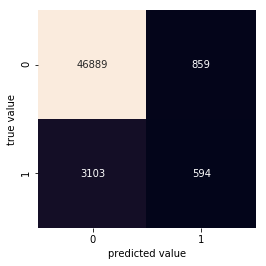

In [37]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True,fmt='d', cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

Overall, logistic regression is not an effective way to model the data, especially because it is so unbalanced (only about 7% of the permanent visa applications are denied). As is clear from the confusion matrix, the model just predicts approval (0) most of the time, making it appear effective (the score is 0.92), but not accurately predicting when an application will be denied.

## Modeling: KNN

I then attempted to model the approval or denial of appplications using scikit-learn's K-Nearest Neighbors model. After adjusting the parameters quite a bit, I determined the best number of neighbors to be 8, and the best algorithm to be "auto".

In [38]:
from sklearn.neighbors import KNeighborsClassifier 

In [39]:
knn = KNeighborsClassifier(n_neighbors=8,algorithm = 'auto')

In [40]:
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
knn.score(X_test, y_test)

0.929614151035086

In [41]:
print(metrics.classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.99      0.94      0.96     50551
          1       0.13      0.54      0.21       894

avg / total       0.98      0.93      0.95     51445



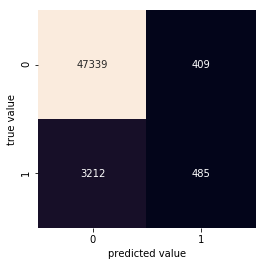

In [42]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d',cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

The KNN model makes an improvement on the logistic regression model (the score increased by 0.6%), but is still not accurately predicting the denial of applications.

## Modeling: Random Forest

Finally, I tried a random forest to model whether applications will be approved or denied. Once again, I spent a lot of time adjusting the class_weight parameter to account for the unbalanced data, but was unable to make an improvement on either of the previous models.

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rfc = RandomForestClassifier(n_estimators=40,class_weight={0:.19, 1:.81})

In [45]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.19, 1: 0.81},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [46]:
y_pred = rfc.predict(X_test)

In [47]:
rfc.score(X_test, y_test)

0.9022062396734376

In [48]:
print(metrics.classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.95      0.95      0.95     47689
          1       0.33      0.32      0.32      3756

avg / total       0.90      0.90      0.90     51445



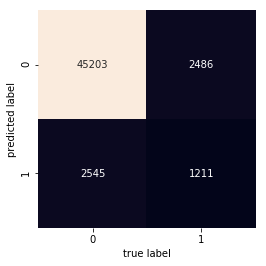

In [49]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

This model has the lowest score of all three (.901), and is significantly less accurate than just predicting all applications will be approved.

Modeling this data set proved very difficult, due to the unbalanced nature of the data. Overall, the K-Nearest Neighbors model was most effective, with a score of 0.9296, an average precision of 98%, and an average recall of 93%. Unfortunately, this is no more accurate  than guessing that all permanent visa applications are approved, since only about 7% are denied.<br> A more complex model and some work with sub-sampling may help create more accurate predictions.

Next: [Presentation](05-Presentation.ipynb)<br>